# Introduction
This self-contained notebook documents an investigation to find relationships between a student's major and those of their friends, as an ancillary to the paper than can be found [here](Modeling_Relationships_Between_Student_Majors_and_Collegiate_Friendships.pdf). I detail my entire process from scraping the data for university students to testing the final statistical models. I also discuss the philosophy of the code and explain concepts such as multiprocessing, model flexibility, and irreducable error.

# Setup
### Imports and Configuration
Let's begin by importing the necessary libraries. 

In [3]:
from multiprocessing import Pool, Queue, Manager, cpu_count
from requests import Session
from time import sleep
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

<div style="background-color:#FFCC00; border-radius:6px">
    <h4 style="text-align:center; padding:5px"><b>Unfortunately, due to the limitations of Jupyter Notebooks, it is not possible to run the code in the following section</b></h4>
    </div>

# Data Scraping
We embark on our journey by collecting data on student friendships and majors. From [Venmo](http://www.venmo.com), a social media and payment app, we collect for each student their list of friends which form their *general friend group* and their transactions to determine their *best* friends. The [Clemson Student Directory](https://my.clemson.edu/) provides information about student majors. 

### Initialization
To manage the program flow and hold state variables, we use basic data structures:
- **Queue** to hold the list of individuals not yet scraped
- **Dictionary** to hold scraped individuals and their student status
- **List** to store collected data

Since data from the Queue and Dictionary will be shared among multiple processors, thread-safe implementations from the multiprocessing library have been used. This ensures that data can safely be accessed and prevents situations such as *race conditions*, in which multiple operations that are to be done sequentially are instead  done simulataneously (such as retrieving an individual from the queue).

In [2]:
directory = Manager().dict()  
q = Queue() 
data = []
proxies = []
sessions = [Session()] * 2

### Methods
For each website to be scraped, a method has been defined. Both methods take in as parameters a Session instance, which preserves state information such as cookies across requests, and a custom-defined Person object, which holds information about the student to be scraped. The methods send requests to the server, validate the returned data, and if no exception has occured, attach the data to the Person object.

Using the *Clemson Student Directory*, this method collects a student's major, class standing, and profile picture. The PersonNotAtClemson exception is raised if an individual is not in the directory.

In [3]:
def get_clemson_data(session, person):
    try:
        data = session.get("https://my.clemson.edu/srv/feed/dynamic/directory/search?name=" + person.name)
        person.cuid = data.json()[0].get('cn')
        data = session.get('https://my.clemson.edu/srv/feed/dynamic/directory/getInfoByCN?cn=' + person.cuid)
        data = data.json()
        if person.name.split() != [data.get('name').get('first'), data.get('name').get('last')]:
            raise PersonNotAtClemson(person)
    except (KeyError, IndexError, AttributeError, URLError):
        raise PersonNotAtClemson(person)
    else:
        try:
            person.class_standing = data.get('student').get('class')
            person.major = data.get('student').get('major').get('name')
            with suppress(Exception):
                urlretrieve(data['photo_url'], 'output/images/' + person.cuid + '.png')
        except AttributeError:
            pass

The Venmo-scraping method takes in an additional parameter, proxy, which is used when sending requests. This masks the original request location, preventing Venmo's servers from detecting unusual traffic. Collected along with a user's list of friends are the sender, recepient, and associated message for each transaction.

In [4]:
def get_venmo_data(session, person, proxy):
    try:
        data = session.get("https://venmo.com/" + person.username, timeout=2, proxies={'https': proxy})
        soup = BeautifulSoup(data.text, 'lxml')
        person.friends = [friend['details'].strip(')').split(' (') for friend in soup(cardtype='profile')]
        if not person.friends:
            raise TooManyRequests if 'Sorry' in data.text else SessionTimeOut

        rgx = re.compile(r"^venmo.page_user.*?id\":\s([0-9]*)", flags=re.MULTILINE)
        person.id = re.search(rgx, data.text).group(1)
        data = session.get("https://venmo.com/api/v5/users/" + person.id + "/feed", timeout=2, proxies={'https':proxy})
        data = data.json()

        person.transactions = [
            [t['actor']['username'], t['transactions'][0]['target']['username'], t['message'], t['created_time']]
            for t in data['data']]
    except RequestException:
        raise NonFatalException(person)

### Scraping
This method retrieves individuals from the queue, rotates proxies, and handles exceptions raised by the scraping helper functions. If no error has occured, the individual is added to the dataset and their friends are added to the queue.

In [5]:
def scrape(i):
    # exit if demand for queue is too high
    try:
        person = Person(q.get(timeout=5))
    except Exception:
        return

    # random proxy to avoid detection
    proxy = 'http://' + np.random.choice(proxies)

    try:
        if person.username in directory:
            raise PersonInDirectory(person)

        get_clemson_data(sessions[0], person)
        get_venmo_data(sessions[1], person, proxy=proxy)

    # exceptions in which individual is not scraped
    except NonFatalException as e:
        if isinstance(e, PersonInDirectory):
            pass
        elif isinstance(e, PersonNotAtClemson):
            directory[person.username] = False

    # exceptions that interrupt program flow
    except FatalException as e:
        if isinstance(e, TooManyRequests):
            pass
        # if session times out, program waits for updated cookies
        elif isinstance(e, SessionTimeOut):
            print("SLEEPING")
            sleep(900)
            load_settings()
        q.put([person.name, person.username])

    # catch other exceptions to prevent termination
    except Exception as e:
        print("UNKNOWN ERROR", e)

    # add person to directory and friends to queue
    else:
        directory[person.username] = True
        [q.put(friend) for friend in person.friends]
        return person.dump()

This method handles multiprocessing and looping of the scrape method.

In [6]:
def run(n):
    print('Scraping started.')
    pool = Pool(cpu_count())
    # keep scraping until either queue is empty or goal is reached
    while not q.empty() and len(data) < n:
        data.extend(filter(None, pool.map(main, range(3000))))
        print("Number of people checked:{}".format(len(directory)))
        print("Number of students scraped:{}".format(len(data)))
        # save data at intervals
        with open('output/directory.pkl', 'wb') as f:
            pickle.dump(dict(directory), f)
        pd.DataFrame(data).to_csv('output/out.csv')
    pool.close()
    print('Scraping Finished')

# Data Preprocessing
The philosophy of "garbage in, garbage out" is particularly applicable to machine learning, and before training the models, we need to strip the data of unecessary information, filter out noisy records, and transform it into something usable. 

### Load Data
I've already begun the process of tidying up the data a little by removing unecessary columns and restoring datatypes not preserved by the csv format such as lists. Let's load the *data.hdf* file into a DataFrame and see what we're working with.


In [4]:
original_df = pd.read_hdf('data.hdf')
original_df.head()

,major,friends,transactions
username,,,
nana99,General Engineering,"[[Erin Jin, yermyam00], [Dev Patel, Devfinitel...","[[nana99, Aleigh-Trotter, 🍞🐷🍞, 2020-03-15T22:2..."
Alfredo-Rojas-4,Biological Sciences,"[[Noah Austin, Noah-Austin-18], [Laura William...",[]
natalieeweaver,Graphic Communications,"[[Jackson Killman, Jackson-Killman], [Alex San...",[]
Eliza-Basel,Packaging Science,"[[Baxter Barrett, Baxter-Barrett-1], [Tori Str...","[[lizzycjordan, Eliza-Basel, last night :’), 2..."
Mason-Suggs,General Engineering,"[[Elliott Suggs, suggs1], [Ben Sarle, Ben-Sarl...","[[Mason-Suggs, KateStewart1325, 🍪, 2019-09-03T..."


### Data Cleaning
Since our models only care about the major of the students (and not their username, for example), let's map all the students to their major. While we're at it, let's also jettison nonessential transaction details.

In [24]:
df = original_df.copy()
directory = df['major'].to_dict()
df['friends'] = df['friends'].apply(lambda f: list(filter(None,map(directory.get, np.array(f)[:, 1]))))

tr = []                                              
for person, trans in zip(df.index, df['transactions']):
    tr.append(list(filter(None, map(directory.get, [t[0] if person is t[1] else t[1] for t in trans]))))
df['transactions'] = tr
 
df.head()

,major,friends,transactions
username,,,
nana99,General Engineering,"[Political Science, Biochemistry, General Engi...","[Computer Science, Computer Science, Computer ..."
Alfredo-Rojas-4,Biological Sciences,"[General Engineering, Biological Sciences, Pre...",[]
natalieeweaver,Graphic Communications,"[Psychology, Parks, Rec And Tour Mgt, Industri...",[]
Eliza-Basel,Packaging Science,"[Chemistry, Elementary Education, Computer Sci...","[Packaging Science, Genetics, Genetics, Bioche..."
Mason-Suggs,General Engineering,"[Secondary Education, Forest Resource Mgt, Gen...","[General Engineering, General Engineering, Gen..."


[Text(0.5, 0, 'Major Size')]

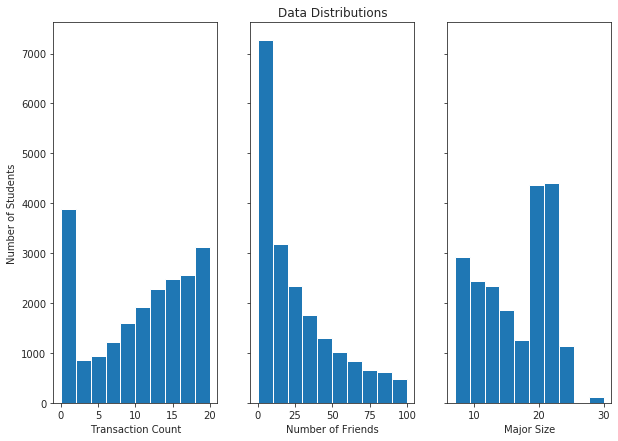

In [26]:
sns.set_style('ticks')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(10,7))
ax1.hist(df['transactions'].apply(len))
ax1.set(ylabel='Number of Students', xlabel='Transaction Count')

ax2.hist(df['friends'].apply(len), range=[0,100])
ax2.set(title='Data Distributions', xlabel="Number of Friends")

ax3.hist(df['major'].apply(len))
ax3.set(xlabel='Major Size')

### Data Transformation
The data looks much more useful now, but it's still useless to a machine. Let's one-hot encode each major into a unique series of numbers, in which the "one" signifies it's index in the list_of_majors.

In [9]:
list_of_majors = set(df['major'])
lookup = dict(zip(list_of_majors, np.eye(len(list_of_majors)))) #  major to sparse encoding
df = df.applymap(lambda x: lookup.get(x) if isinstance(x,str) else list(map(lookup.get, x))) # encode dataframe
df.head()

,major,friends,transactions
username,,,
nana99,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
Alfredo-Rojas-4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[]
natalieeweaver,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[]
Eliza-Basel,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
Mason-Suggs,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


By converting the Series (DataFrame columns) into a matrix, we can take advantage of the speed and usability of Numpy ndarrays. Matrices must have equal size-vectors axes so each list of friends is summed into a single vector without any information loss. Now the value for each index in a vector also shows the *count* of friends in the corresponding major.

In [10]:
df = df[(df['friends'].apply(len) != 0) & (df['transactions'].apply(len) != 0)]
m = np.array([df['major'].tolist(), df['friends'].apply(sum).tolist(), df['transactions'].apply(sum).tolist()])
m

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

### Data Reduction
Keeping in line with the "garbage in, garbage out" philosophy, let's remove individuals with insufficient data. These are individuals who have a low number of friends or transactions, or are in really small majors. Feel free to experiment with these parameters to see how they affect model performance. 

In [11]:
min_friends = 5
min_transactions = 5
min_major_size = 1

m = m[...,m[0].sum(0) >= min_major_size]
m = m[:,np.logical_and(np.logical_and(m[1].sum(1) >= min_friends,m[2].sum(1) >= min_transactions), m[0].sum(1) > 0),]

### Data Normalization
To reduce model sensitivity to the differences in the number of friends, vectors are converted from *count* of friends in a major to the *proportion* of friends in that major. 

In [12]:
m = [x/x.sum(1, keepdims=1) for x in m]

The train_test_split method shuffles the data and creates sets of training and test data. The default split is 80/20.

| Training | Test    | Description                                                 |
|:----------|:---------|:-------------------------------------------------------------|
| train_x1 | test_x1 | Distribution of majors among all of an individual's friends |
| train_x2 | test_x2 | Distribution of majors among only transaction-based friends      |
| train_y  | test_y  | Expected student majors labels                                              |

In [13]:
train_y, test_y, train_x1, test_x1, train_x2, test_x2 = train_test_split(*m)

# Model Creation

### Neural Network
Finally, let's create and train a simple one-layer neural network and see how well it can predict a student's major based on their general friend group (Dataset $x_{1}$).

In [14]:
model_1 = Sequential([Dense(200, input_dim=train_x1.shape[1]), Dense(train_x1.shape[1]), Activation('softmax')])
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
model_1.fit(x=train_x1, y=train_y, epochs=15, batch_size=10, verbose=1)

Train on 9487 samples
Epoch 1/15
9487/9487 [==============================] - 3s 299us/sample - loss: 3.8352 - accuracy: 0.1337 - top_k_categorical_accuracy: 0.3627
Epoch 2/15
9487/9487 [==============================] - 2s 253us/sample - loss: 3.3206 - accuracy: 0.2355 - top_k_categorical_accuracy: 0.4975
Epoch 3/15
9487/9487 [==============================] - 2s 255us/sample - loss: 3.1362 - accuracy: 0.2715 - top_k_categorical_accuracy: 0.5445
Epoch 4/15
9487/9487 [==============================] - 2s 258us/sample - loss: 3.0336 - accuracy: 0.2903 - top_k_categorical_accuracy: 0.5723
Epoch 5/15
9487/9487 [==============================] - 2s 258us/sample - loss: 2.9659 - accuracy: 0.3023 - top_k_categorical_accuracy: 0.5803
Epoch 6/15
9487/9487 [==============================] - 2s 257us/sample - loss: 2.9163 - accuracy: 0.3112 - top_k_categorical_accuracy: 0.5964
Epoch 7/15
9487/9487 [==============================] - 2s 250us/sample - loss: 2.8771 - accuracy: 0.3201 - top_k_catego

In [15]:
def evaluate(preds):
    return np.mean(np.argmax(test_y, axis=1) == preds)

In [16]:
nn1_preds = np.argmax(model_1.predict(test_x1), axis=1)
evaluate(nn1_preds)

0.31362630414163767

Our model was able to predict a student's major correctly over a third of the time! Let's now try training with the second set of data, using only an individual's closest friends (dataset ${x_2}$).

In [17]:
model_2 = Sequential([Dense(200, input_dim=train_x1.shape[1]), Dense(train_x1.shape[1]), Activation('softmax')])
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
model_2.fit(x=train_x2, y=train_y, epochs=15, batch_size=10, verbose=0)

In [18]:
nn2_preds = np.argmax(model_2.predict(test_x2), axis=1)
evaluate(nn2_preds)

0.9313942459690168

Wow, what a staggering difference! Our model had ~93% accuracy when using only an individual's closest friends. To fairly evaluate these results, let's create a simple baseline by taking the most frequent major among a person’s closest friends. 

In [19]:
baseline_1 = np.argmax(test_x1, axis=1)
baseline_2 = np.argmax(test_x2, axis=1)
evaluate(baseline_1), evaluate(baseline_2)

(0.3171040151754663, 0.9399304457793234)

What happened? Most likely due to overfitting, the Neural Networks were outperformed by the baselines! Let's see if we can perform better by creating simpler and less flexible models.

In [20]:
train_y_non_sparse = [np.argmax(y) for y in train_y]

In [21]:
def test_model(model, name):
    df = pd.DataFrame()
    model.fit(train_x1, train_y_non_sparse)
    df['x1'] = model.predict(test_x1)
    model.fit(train_x2, train_y_non_sparse)
    df['x2'] = model.predict(test_x2)
    df['Model'] = name
    return df

### Logistic Regression

In [22]:
clf = LogisticRegression()
clf_preds = test_model(clf, 'Logistic Regression')

/home/aru/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### K-Nearest Neighbors

In [23]:
neigh = KNeighborsClassifier(n_neighbors = 10)
neigh_preds = test_model(neigh, 'K-Nearest Neigbors')

### Decision Tree

In [24]:
tree = DecisionTreeClassifier()
tree_preds = test_model(tree, 'Decision Tree')

# Results

Finally, let's calculate the performance of all these models and compare them.

In [25]:
baseline_preds = pd.DataFrame({'Model':'Baseline', 'x1':baseline_1, 'x2':baseline_2})
nn_preds = pd.DataFrame({'Model':'Neural Network', 'x1': nn1_preds, 'x2':nn2_preds})
results = pd.concat((baseline_preds, clf_preds, neigh_preds, tree_preds, nn_preds))
results = results.melt(id_vars='Model', value_vars=['x1', 'x2'], var_name='Dataset', value_name='Preds')
results

,Model,Dataset,Preds
0,Baseline,x1,88
1,Baseline,x1,84
2,Baseline,x1,79
3,Baseline,x1,0
4,Baseline,x1,47
...,...,...,...
31625,Neural Network,x2,86
31626,Neural Network,x2,61
31627,Neural Network,x2,111
31628,Neural Network,x2,126


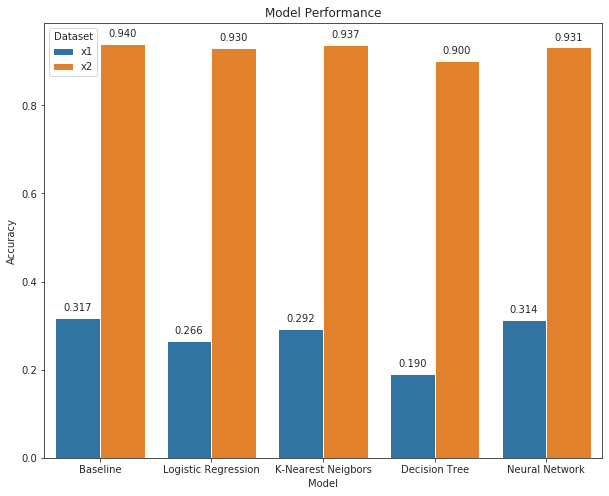

In [27]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(10, 8))
plt = sns.barplot(ax=ax, x='Model', y='Preds', data=results, hue='Dataset', estimator=evaluate, ci=None)
plt.set(title='Model Performance', ylabel='Accuracy')

# add accuracies to top of bars
for p in plt.patches:
    plt.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Conclusions

Model performances were just shy of the baselines, with the Neural Network outperforming all the models for the first dataset, but coming in second to K-Nearest Neighbors for the second dataset. Surprisingly, the least flexible model, Logistic Regression, came second to last, only performing better than Decision Trees. The models possibly underperformed due to unobserved factors, including social ones such as membership in a sports team or organization, which may have taken precedence over major in influencing one’s best friends, as well as biases in the data itself, as Venmo is increasingly being used to pay strangers. Collectively, these factors form the irreducible error, which limits how well these models can approximate the true friendships-student-major relationship.

# Extras

### Graph Creation
Modeling relationships using a graph can help you uncover macroscale patterns not possible with other modeling techniques.

In [20]:
graph_df = original_df.copy()[:graph_size]
graph_df['friends'] = graph_df['friends'].apply(lambda f: list(filter(None,map(directory.get, np.array(f)[:, 1]))))

In [18]:
G = nx.Graph()
max_nodes = 100 # drawing demo purposes
for student, friends in zip(graph_df.index, graph_df['friends']):
    if G.number_of_nodes() >= max_nodes:
        break
    for friend in friends:
        G.add_edge(student, friend)

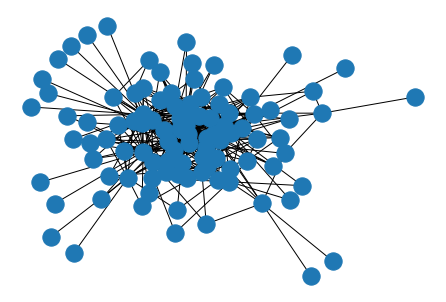

In [19]:
nx.draw(G)

We were able to draw a cursory graph using Networkx, but for [advanced visualizations](Visuals/graph/graph_with_labels.png) and deeper graph analysis, it is recommended to use external software such as [Gephi](https://gephi.org/).

In [ ]:
nx.write_graphml(G,'data/graph.graphml') # export graph